# Prereqs

In [6]:
import pandas as pd
import numpy as np
import gzip
import rpy2.robjects as robjects
from rpy2.robjects import pandas2ri
from rpy2.robjects.packages import importr
from rpy2.robjects import r
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from IPython.display import Image

pd.set_option('display.max_rows', None)

# Import data and process

In [7]:
data_dir = "/Users/patrick/Documents/Data/DKS/"

Import Mutation Annotation Format file:

In [8]:
maf_path = data_dir + "mc3.v0.2.8.PUBLIC.maf.gz"

with gzip.open(maf_path, 'rt') as file:
    maf = pd.read_csv(file, sep = '\t', comment = '#', low_memory = False)

print("Total mutations loaded:", len(maf))

Total mutations loaded: 3600963


Import clinical, sample, gene expression, and Bagaev annotation data:

In [10]:
clinical = pd.read_csv(data_dir + "clinical.project-tcga-skcm.2025-05-02/clinical.tsv", sep='\t')

sample = pd.read_csv(data_dir + "biospecimen.project-tcga-skcm.2025-05-03/sample.tsv", sep = '\t')

expr = pd.read_csv(data_dir + "TCGA-SKCM.star_fpkm.tsv", sep= '\t', index_col = 0)

bag = pd.read_excel(data_dir + "mmc2.xlsx", sheet_name = 2, header = 1)

gencode_map = pd.read_csv(data_dir + "gencode.v36.annotation.gtf.gene.probemap", sep='\t')

Get primary tumor samples only:

In [11]:
primary_samples = sample[sample['samples.sample_type'] == 'Primary Tumor']
print("Total number of samples:", primary_samples.shape[0])

sample_counts = primary_samples['samples.submitter_id'].value_counts()
num_with_multiple = (sample_counts > 1).sum()
print(f"{num_with_multiple} patients have multiple primary tumor samples.")

Total number of samples: 396
0 patients have multiple primary tumor samples.


Filter MAF file for these primary tumors:

In [12]:
primary_barcodes = primary_samples['samples.submitter_id']
maf['sample_barcode'] = maf['Tumor_Sample_Barcode'].str.slice(0, 16)
skcm_maf = maf[maf['sample_barcode'].isin(primary_barcodes)]
print(f"SKCM primary tumor mutations: {len(skcm_maf)}")

SKCM primary tumor mutations: 79214


Mutation types and frequencies:

In [13]:
mutation_summary = pd.DataFrame({
    'Count': maf['Variant_Classification'].value_counts(),
    'Percent': (maf['Variant_Classification'].value_counts(normalize=True) * 100).round(2)
})
mutation_summary

,Count,Percent
Variant_Classification,,
Missense_Mutation,1921979,53.37
Silent,782687,21.74
3'UTR,282636,7.85
Nonsense_Mutation,157232,4.37
Intron,108104,3.00
Frame_Shift_Del,87013,2.42
5'UTR,81323,2.26
Splice_Site,50617,1.41
RNA,49540,1.38


Non synonymous mutations only:

In [14]:
non_synonymous = ['Missense_Mutation','Nonsense_Mutation','Frame_Shift_Del',
    'Frame_Shift_Ins','Splice_Site','Translation_Start_Site',
    'In_Frame_Del','In_Frame_Ins','Nonstop_Mutation'
]

ns_maf = skcm_maf[skcm_maf['Variant_Classification'].isin(non_synonymous)]
print(f"Non-synonymous mutations: {len(ns_maf)}")

Non-synonymous mutations: 47273


TMB per sample:

In [15]:
tmb_counts = (
    ns_maf['Tumor_Sample_Barcode']
    .value_counts()
    .rename_axis('sample_barcode')
    .reset_index(name='mutation_count')
)

tmb_counts['TMB'] = (tmb_counts['mutation_count'] / 38)
tmb_counts['TMB_bin'] = pd.qcut(tmb_counts['TMB'], q = 3, labels = ['Low', 'Medium', 'High'])

In [16]:
tmb_counts.head()

,sample_barcode,mutation_count,TMB,TMB_bin
0,TCGA-FR-A726-01A-11D-A32N-08,5776,152.000000,High
1,TCGA-BF-A1Q0-01A-21D-A19A-08,2592,68.210526,High
2,TCGA-GN-A26C-01A-11D-A19A-08,2412,63.473684,High
3,TCGA-YG-AA3N-01A-11D-A38G-08,1644,43.263158,High
4,TCGA-BF-A1PZ-01A-11D-A19A-08,1594,41.947368,High


# Gene expression based T-cell classification

In [17]:
bag.head()

,Gene,Gene signature,Description,PMID
0,ANGPT1,Angiogenesis,"ANGPT1 functions as a TIE2 agonist, which indu...",20651738
1,ANGPT2,Angiogenesis,ANGPT2 normally functions as an ANGPT1antagoni...,20651738
2,CDH5,Angiogenesis,Vascular endothelial (VE)-cadherin is specific...,16256984
3,CXCL5,Angiogenesis,"CXCL5, a member of the CXC chemokine family, h...",21356384
4,CXCL8,Angiogenesis,IL8 is a proinflammatory CXC chemokine associa...,18980965


In [18]:
expr.index = expr.index.str.replace(r"\..*", "", regex = True)

In [19]:
gencode_map['Ensembl_ID'] = gencode_map['id'].str.replace(r"\.\d+$", "", regex = True)

In [50]:
def pathway_expr(pathway_name):
    genes = bag[bag['Gene signature'] == pathway_name]['Gene'].unique()
    matches = gencode_map[gencode_map['gene'].isin(genes)]['Ensembl_ID'].unique()
    gene_expr = expr.loc[expr.index.intersection(matches)]
    return gene_expr

In [61]:
pathway_angio = pathway_expr("Angiogenesis")

In [80]:
pandas2ri.activate()
robjects.globalenv['expr_values'] = robjects.FloatVector(pathway_angio.iloc[0, :])
robjects.r('''
    library(ggplot2)
    df <- data.frame(expression = expr_values, trans_expr = log2(expr_values + 1e-4))
    p <- ggplot(df, aes(x = expression)) + theme_bw() +
        geom_histogram(binwidth = 0.2, fill = "steelblue", color = "black")
    p2 <- ggplot(df, aes(x = trans_expr)) + theme_bw() +
        geom_histogram(binwidth = 0.2, fill = "steelblue", color = "black")
    ggsave(filename = "gene_expression_hist_r.png", plot = p, width = 6, height = 4, dpi = 300)
    ggsave(filename = "trans_gene_expression_hist_r.png", plot = p2, width = 6, height = 4, dpi = 100)
''')

array(['trans_gene_expression_hist_r.png'], dtype='<U32')

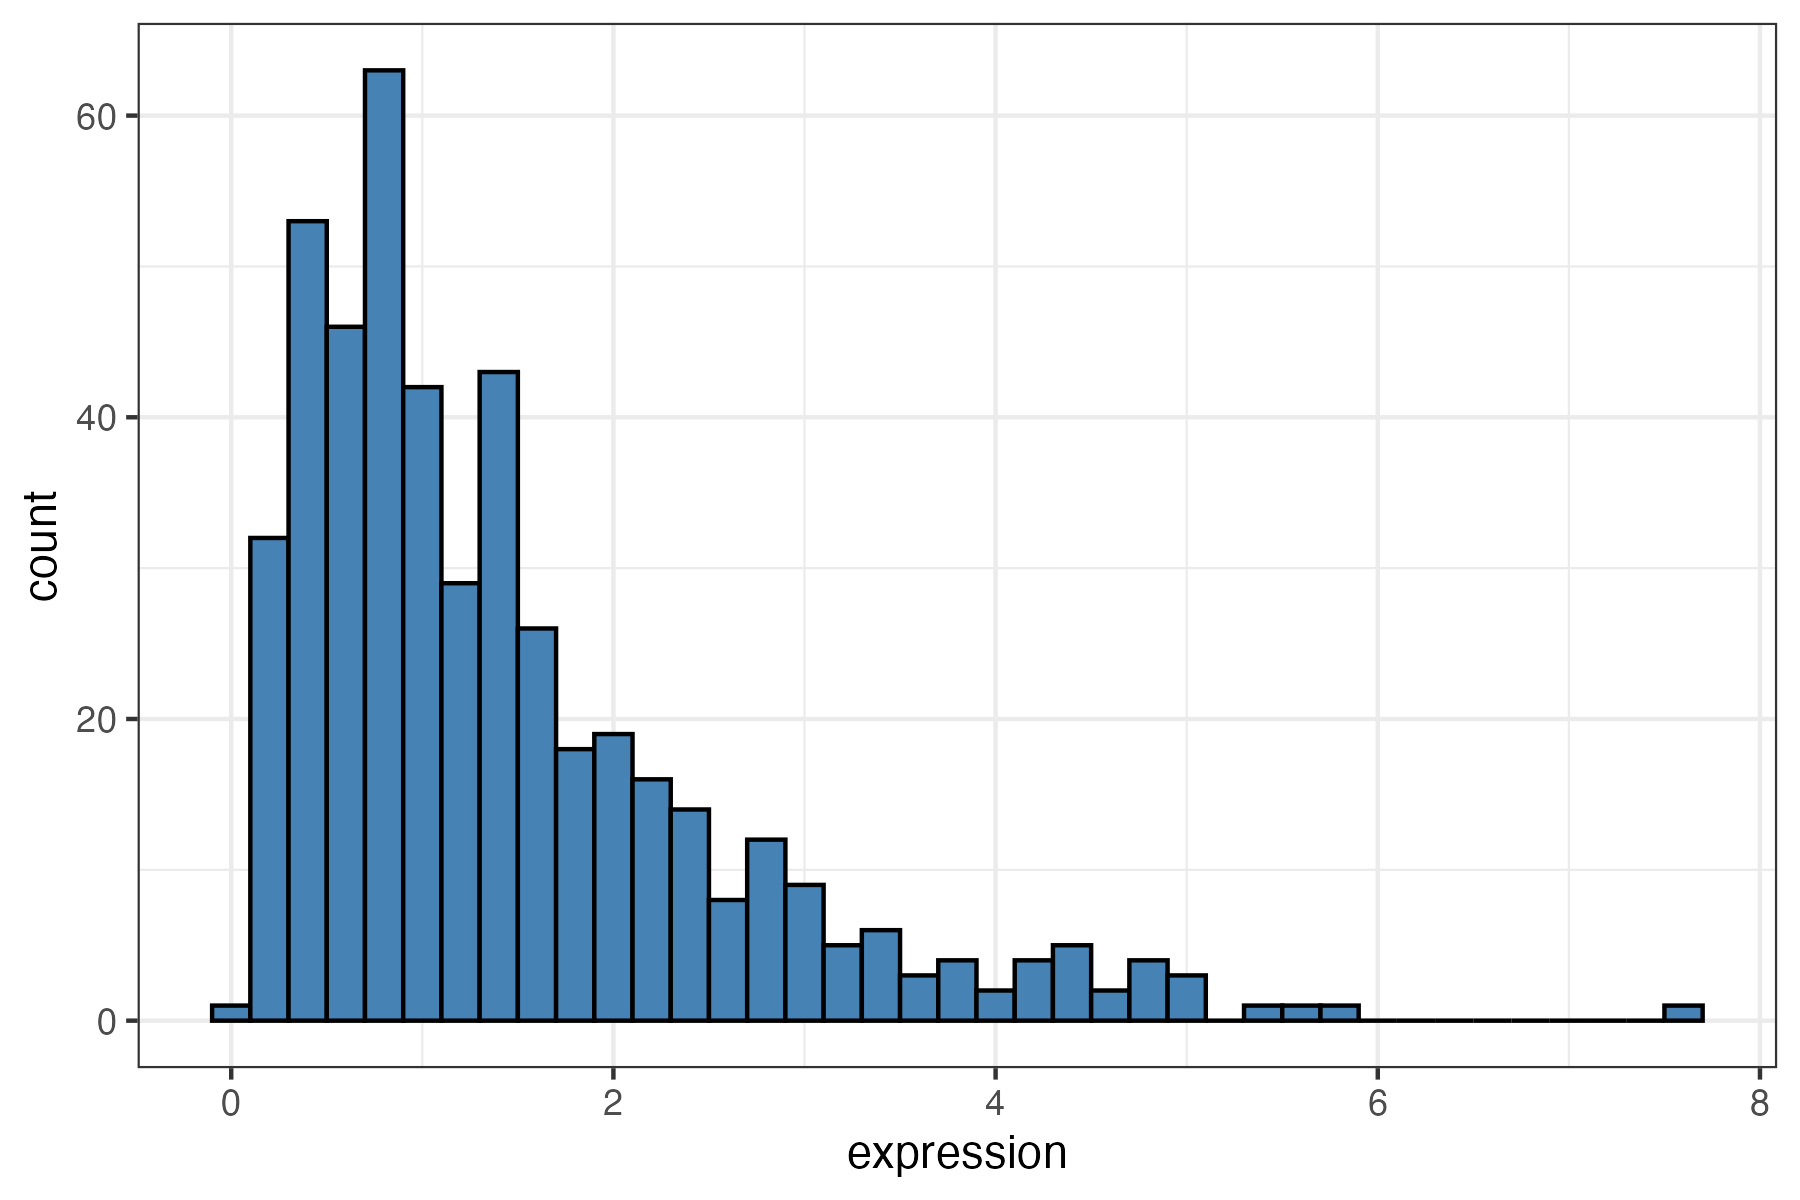

In [81]:
Image(filename = "gene_expression_hist_r.png")

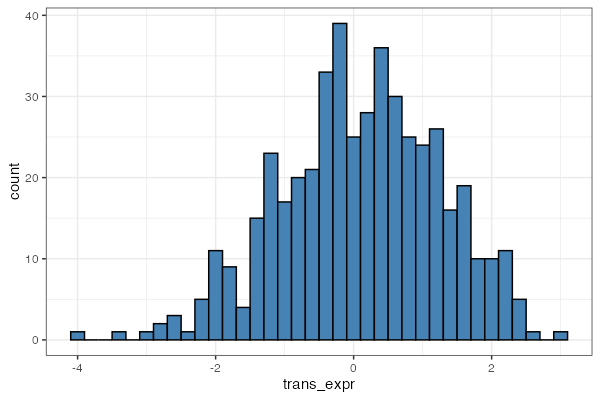

In [82]:
Image(filename = "trans_gene_expression_hist_r.png")

In [78]:
def trans_pca(pathway_name):
    gene_expr = pathway_expr(pathway_name)
    trans_gene_expr = np.log2(gene_expr + 1e-4)
    scaled_expr = StandardScaler().fit_transform(trans_gene_expr.T)
    scaled_expr = pd.DataFrame(scaled_expr, index = gene_expr.columns, columns = gene_expr.index)
    pca = PCA(n_components = 1).fit_transform(scaled_expr)
    return pd.DataFrame(pca, index = scaled_expr.index, columns = ['PC1'])

In [79]:
trans_pca("Angiogenesis")

,PC1
TCGA-ER-A199-06A,1.582147
TCGA-EE-A3J5-06A,0.605777
TCGA-EE-A2ME-06A,3.581059
TCGA-BF-A5ES-01A,-4.343402
TCGA-D3-A8GE-06A,3.080611
TCGA-EE-A2MG-06A,3.866237
TCGA-EE-A2MR-06A,1.987174
TCGA-DA-A1HY-06A,3.244494
TCGA-FR-A44A-06A,-0.359745
TCGA-RP-A6K9-06A,1.929747


# Pan cancer atlas immune subtypes (C1-C6)